# Vorstellung von CycleGAN
Ziel ist es, ein Bild von der Quelldomäne X in die Zieldomäne Y zu übertragen, wenn keine paarweisen Beispiele vorhanden sind.  Das Mapping, G:X->Y, wird so gelernt, dass die Verteilung von G(X) nicht von der Verteilung Y abweicht. Da dieser Prozess underconstrained ist, benötigt man einen weiteren inversen Prozess F: Y->X, mit dem man den zyklischen Konsistenzverlust minimieren kann, d.h. F(G(X)) ist fast gleich X.
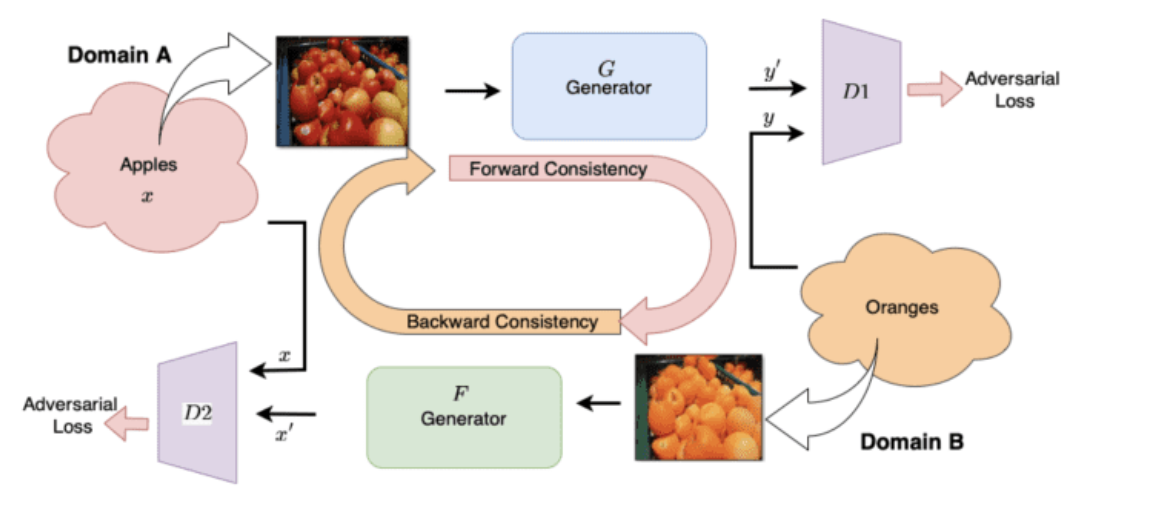


In [2]:

import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE  
print(tf.__version__)





# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of replicas: 1
2.6.4


In [3]:
m_filename = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
p_filename = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

def decode_image(image):
    # decode image into tensor
    #decodes the JPEG-encoded image. The channels=3 argument specifies that the image is in color (RGB with 3 channels).   
    image = tf.image.decode_jpeg(image, channels=3)
    print("data after decode:", image)
    
    print(type(image))
    # is used to convert the data type of the image. 
    # Images are typically loaded in an integer format (e.g., uint8), but neural networks work better with floating-point numbers.
    image = tf.cast(image, tf.float32)
    
    # Neural networks generally perform better and converge faster when the input data is normalized. 
    # This is because normalization makes the training less sensitive to the scale of features, allowing the network to learn more effectively.
    # dividing by 127.5, they are in the range [0, 2], and '-1' shifts the range from [0, 2] to a more neural network-friendly range of [-1, 1]
    image = image/127.5 - 1

    #This is necessary to ensure a consistent size for all images that will be input to a model.
    image = tf.reshape(image, [256, 256, 3])

    return image
    
def process_tfrecord(example):
    # tfrecord is binary file format, stores data as a sequence of binary strings 
    # configuration for parsing a fixed-length input feature, defining the structure of a feature  tf.io.FixedLenFeature(shape,dtype)
    # convert example to a dictionary of Features(lists of values, which have specific "types"), to easily serialize it
    tfrecord_format = {
        "image_name" : tf.io.FixedLenFeature([], tf.string),
        "image" : tf.io.FixedLenFeature([], tf.string),
        "target" : tf.io.FixedLenFeature([], tf.string)
    }
    # parse the single example (a serialized TFRecord) using the format defined in tfrecord_format. 
    # parse serialized examples into a dictionary  mapping keys 
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    print("data after read:", image)
    return image

def load_data(filename, labeled=True, ordered=False):
    # load the TFRecord data
    ds = tf.data.TFRecordDataset(filename)
    ds = ds.map(process_tfrecord, num_parallel_calls=autotune)
    return ds



monet_ds = load_data(m_filename, labeled=True).batch(1)
photo_ds = load_data(p_filename, labeled=True).batch(1)

data after decode: Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
<class 'tensorflow.python.framework.ops.Tensor'>
data after read: Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
data after decode: Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
<class 'tensorflow.python.framework.ops.Tensor'>
data after read: Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)


original photos


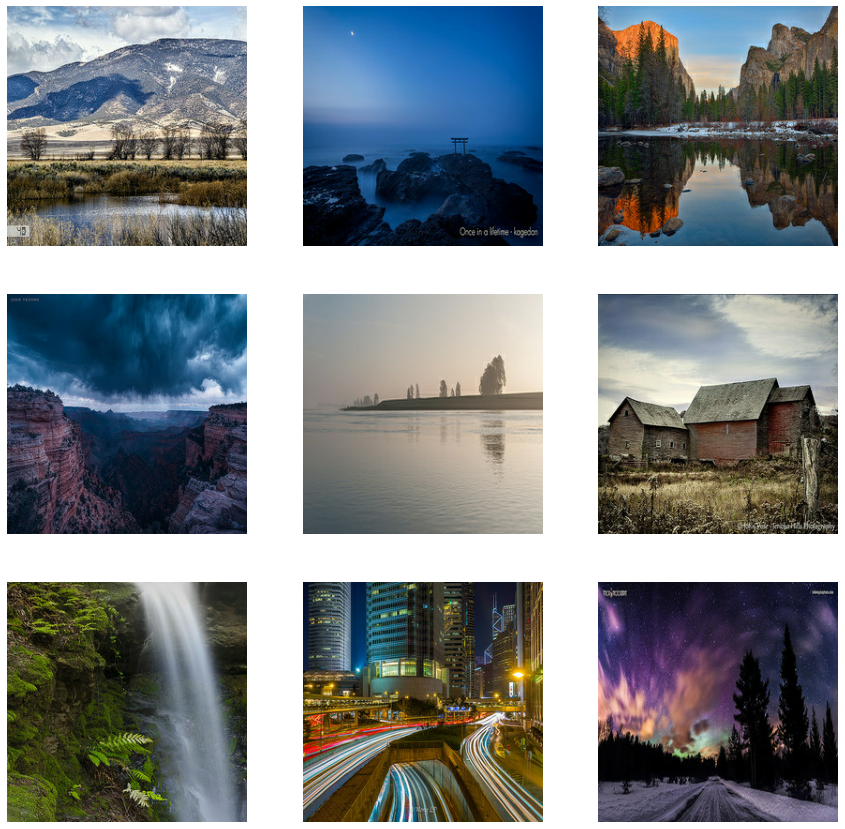

monet paintings


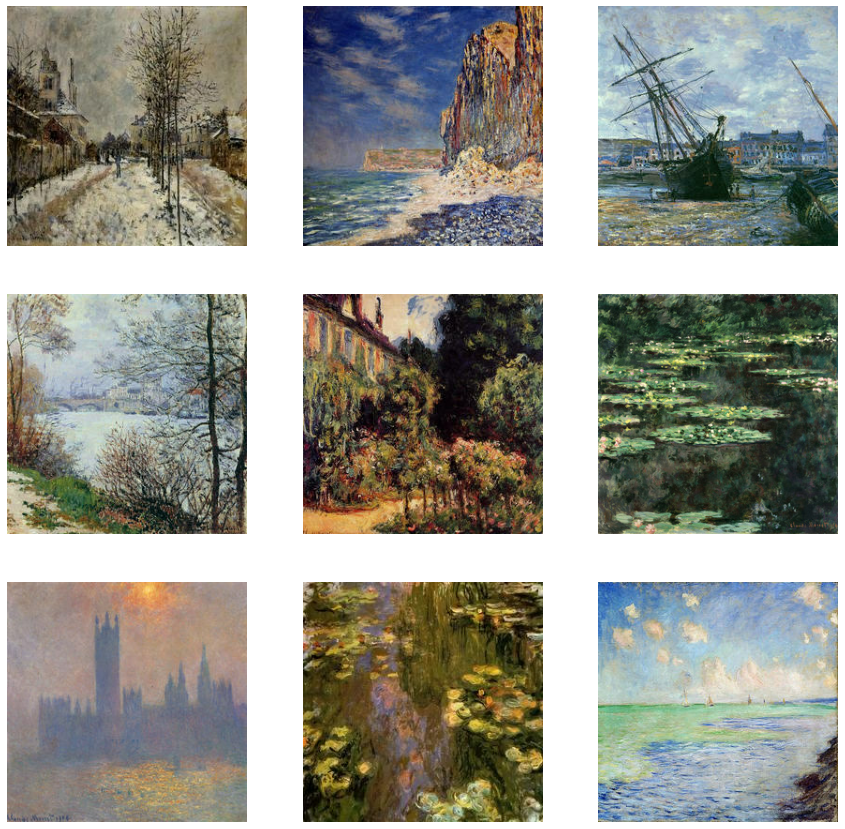

In [5]:

def display_samples(ds, row, col):
    
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    
    plt.show()
    
print('original photos')
display_samples(photo_ds,3,3)
print('monet paintings')
display_samples(monet_ds,3,3)

# Build the generator
The `downsample`, reduces the 2D dimensions, the width and height, of the image by stride. It reduces the complexitiy of the data.

In der `downsample` werden zwei verschiedene Initialisierer verwendet, weil es ermöglicht, die Initialisierungsmethode an die spezifischen Anforderungen jeder Schicht im Modell anzupassen.

Bei der Normalisierung wird anstelle der Batch-Normalisierung die Instanz-Normalisierung verwendet.
InstanceNormalization ist eine Schicht, die oft in GANs verwendet wird, um die Eingaben innerhalb eines jeden Datensatzes (Batch) zu normalisieren. Die Normalisierung ist wichtig, um sicherzustellen, dass die Verteilung der Eingabedaten nicht die Lernprozesse im Netzwerk beeinträchtigt.
Für jede Instanz (z.B. ein Bild im Batch) werden die Feature-Maps unabhängig normalisiert, indem der Mittelwert auf null und die Varianz auf eins gesetzt werden. D.h. im Gegensatz zur Batch Normalization, die über den gesamten Batch von Daten normalisiert, fokussiert sich Instance Normalization auf einzelne Datenpunkte im Batch.

In [20]:
# reduce the 2D dimensions, the width and height, of the image by the stride

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    #mean: der Mittelwert der Normalverteilung, standardmäßig 0
    #stddev: die Standardabweichung der Verteilung, standardmäßig 0.05
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters = filters,
                            kernel_size = size,
                            strides = 2,
                            padding = 'same',
                            kernel_initializer = initializer,
                            use_bias = False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
    
    result.add(layers.LeakyReLU())
    
    return result

Die`upsample` macht das Gegenteil von `downsample`, d.h. die Dimension des Bildes zu vergrößern.

In [28]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev = 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters = filters,
                                     kernel_size = size,
                                     strides = 2,
                                     padding = 'same',
                                     kernel_initializer = initializer,
                                     use_bias = False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.LeakyReLU())
    
    return result

Der Generator wird durch downsamples gefolgt von upsamples gebildet, es gibt also auch eine Long-Skip-Verbindung, die das Vanishing-Gradient-Problem durch Zusammenfügen der Ausgabe mehrerer Layer reduziert.

Das Problem des verschwindenden Gradienten bedeutet, dass der Gradient, der das Netz aktualisiert, sehr klein wird. Es tritt im Prozess auf, wenn der Gradient von der Ausgabeschicht backpropogated wird.

In [30]:
OUTPUT_CHANNELS = 3
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    
    down_stack = [downsample(64,(4,4), apply_instancenorm=False),#batch-size: 128,128(image size),64(dimensionality)
                  downsample(128,4),#batch-size: 64,64,128
                  downsample(256,4),#batch-size: 32,32,256
                  downsample(512,4),#batch-size: 16,16,512
                  downsample(512,4),#batch-size: 8,8,512
                  downsample(512,4),#batch-size: 4,4,512
                  downsample(512,4),#batch-size: 2,2,512
                  downsample(512,4),#batch-size: 1,1,512
                 ]
    up_stack = [upsample(512,4, apply_dropout=True),#batch-size: 2,2,1024
                upsample(512,4, apply_dropout=True),#batch-size: 4,4,1024
                upsample(512,4, apply_dropout=True),#batch-size: 8,8,1024
                upsample(512,4),#batch-size: 16,16,1024
                upsample(256,4),#batch-size: 32,32,512
                upsample(128,4),#batch-size: 64,64,256
                upsample(64,4) #batch-size: 128,128,128
               ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')#batch-size: 256,256,3
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    # 
    skips = reversed(skips[:-1])
    
    # Upsampling through the model
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # helps to bypass the vanishing gradient problem
        x = layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return keras.Model(inputs = inputs, outputs = x)

# Building the Discriminator
Der Diskriminator nimmt das Eingangsbild und klassifiziert, ob es sich um ein echtes oder vom Generator erzeugtes Bild handelt. Anstelle eines einzelnen Nodes erzeugt der Diskriminator ein kleines 2D-Bild mit einem höheren Pixelwert, der ein echtes Bild anzeigt, oder mit einem niedrigeren Pixelwert, der ein gefälschtes Bild anzeigt.

In [8]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    inputs = layers.Input(shape=[256,256,3])
    
    x = inputs
    
    d1 = downsample(64, 4, False)(x) #(128,128,64)
    d2 = downsample(128, 4)(d1) #(64,64,128)
    d3 = downsample(256, 4)(d2) #(32,32,256)
    
    # Fügt um das Bild eine zusätzliche Rand von Nullen hinzu, um die Dimensionen für die nachfolgende Convolution anzupassen.
    zero_pad1 = layers.ZeroPadding2D()(d3) #(34,34,256)
    
    #Erhöht die Anzahl der Feature-Map
    conv = layers.Conv2D(512, 4, strides=1, 
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1) #(31,31,512)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) #(33,33,512)
    
    #für jedes der 30x30 Pixel eine Bewertung erfolgt
    outputs = layers.Conv2D(filters=1, 
                            kernel_size=4, 
                            strides=1,
                            kernel_initializer = initializer)(zero_pad2) #(30,30,1)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    

# Loss Functions
### Generator Loss
Da der Generator den Discriminator darüber täuschen will, dass das vom Generator erzeugte Bild echt ist, benötigt der Generator einen Matrixausgang vom Discriminator mit nur 1s. Daher wird der Loss so berechnet.

In [9]:
# Diese Verteilungsstrategien ermöglichen es, das Training von Modellen auf verschiedene Weisen zu skalieren, sei es auf mehrere GPUs auf einem einzelnen Rechner oder sogar über mehrere Rechner hinweg.
with strategy.scope():
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction = tf.keras.losses.Reduction.NONE)
        # compare the output of discriminator to a matrix of 1s
        loss = bce(tf.ones_like(generated),generated)
        return loss
    

### Discriminator Loss
Die Discriminator-Loss-Funktion vergleicht das echte Bild mit einer Matrix von 1s und das gefälschte Bild mit einer Matrix von 0s. Ein perfekter Diskriminator liefert eine Matrix aus 1s für das echte Bild und eine Matrix aus 0s für das gefälschte Bild.

In [11]:
with strategy.scope():
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
        
        real_loss = bce(tf.ones_like(real), real)
        
        generated_loss = bce(tf.ones_like(generated), generated)
        
        total_loss = generated_loss + real_loss
        
        #output the average of the real and generated loss
        return total_loss * 0.5
        

### Cycle consistency loss
Es vergleicht das Originalbild mit dem zweimal konvertierten Bild. 

`Lambda` dient dazu, das Gewicht des Zyklus-Konsistenzverlustes im Verhältnis zu anderen und Verlustkomponenten im Gesamttrainingsprozess des CycleGAN zu bestimmen.

In [41]:
with strategy.scope():
    def cycle_loss(real_image, cycled_image, Lambda):
        # Computes the mean of elements across dimensions of a tensor.
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return Lambda * loss

### Identity Loss
Der Identitätsverlust vergleicht das Bild mit dem entsprechenden Generator. Wenn ein Bild eingegeben wird, wird ein identisches Bild erwartet.

In [43]:
with strategy.scope():
    def identity_loss(real_image, same_image, Lambda):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return Lambda * 0.5 * loss
        

# CycleGAN Model
Grundkonzept:
*  Cycled Loss F(G(x)) - x
*  Generator1(Quelledomäne -> Zieldomäne) Loss: F(photo) - monet
*  Generator2(Zieldomäne -> Quelledomäne) Loss: G(monet) - photo
*  Discriminator Loss: 


In [53]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator,lambda_cycle=10):
        #ruft von eine übergeordneten oder Basisklasse auf
        super(CycleGAN,self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_dis = monet_discriminator
        self.p_dis = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_dis_optimizer, p_dis_optimizer, gen_loss_fn, dis_loss_fn,cycle_loss_fn, identity_loss_fn):
        super(CycleGAN,self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_dis_optimizer = m_dis_optimizer
        self.p_dis_optimizer = p_dis_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.dis_loss_fn = dis_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        # store the gradients in the tape so that it can keep track of the gradients of your computation and then apply these gradients to an optimiser.
        # Wenn persistent=True setzt wird, bleibt das Tape auch nach dem ersten Aufruf von tape.gradient() erhalten und kann für weitere Gradientenberechnungen wiederverwendet werden. 
        with tf.GradientTape(persistent=True) as tape:
            # Photo -> Monet -> Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # Monet -> Photo -> Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo,training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            #  output from the discriminator by inputing real images, for perfrct discriminator, should be a matrix with all 1s
            dis_real_monet = self.m_dis(real_monet, training=True)
            dis_real_photo = self.p_dis(real_photo, training=True)
            
            # output from the discriminator by inputing faked images, for perfrct discriminator, should be a matrix with all 0s
            dis_fake_monet = self.m_dis(fake_monet, training=True)
            dis_fake_photo = self.p_dis(fake_photo, training=True)
            
            # evaluates the loss of generator, which means compare the output matrix of discriminator(if true, a matrix of 1s)
            monet_gen_loss = self.gen_loss_fn(dis_fake_monet)
            photo_gen_loss = self.gen_loss_fn(dis_fake_photo)
            
            # evaluates the loss of total cycle consistency 
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # evaluates the total loss of generator
            total_monet_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # evaluated the loss of discriminator
            monet_dis_loss = self.dis_loss_fn(dis_real_monet, dis_fake_monet)
            photo_dis_loss = self.dis_loss_fn(dis_real_photo, dis_fake_photo)
            
            # calculate the gradient for generator and discrinimator
            monet_gen_gradient = tape.gradient(total_monet_loss, self.m_gen.trainable_variables)
            # trainable_variables umfasst eine Liste aller Variablen (wie Gewichte und Bias-Werte) innerhalb des Modells, die während des Trainingsprozesses aktualisiert werden können.
            photo_gen_gradient = tape.gradient(total_photo_loss, self.p_gen.trainable_variables)
            
            monet_dis_gradient = tape.gradient(monet_dis_loss, self.m_dis.trainable_variables)
            photo_dis_gradient = tape.gradient(photo_dis_loss, self.p_dis.trainable_variables)
            
            # apply the gradients to the optimizer
            # 'apply_gradient' aktualisiert die trainierbaren Parameter eines Modells basierend auf den berechneten Gradienten
            # 'zip()' kombiniert die Gradienten und die zugehörigen Variablen (trainierbare Parameter des Modells)
            self.m_gen_optimizer.apply_gradients(zip(monet_gen_gradient, self.m_gen.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_gen_gradient, self.p_gen.trainable_variables))
            
            self.m_dis_optimizer.apply_gradients(zip(monet_dis_gradient, self.m_dis.trainable_variables))
            self.p_dis_optimizer.apply_gradients(zip(photo_dis_gradient, self.p_dis.trainable_variables))
            
            return {"monet_gen_loss": total_monet_loss,
                    "photo_gen_loss": total_photo_loss,
                    "monet_dis_loss": monet_dis_loss,
                    "photo_dis_loss": photo_dis_loss}
            
            
        
        
        

# Training the CycleGAN model
 ### Generator and Discrinimator

In [32]:
with strategy.scope():
    m_gen = Generator()
    p_gen = Generator()
    
    m_dis = Discriminator()
    p_dis = Discriminator()

### Optimizer

In [33]:
with strategy.scope():
    m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    m_dis_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    p_dis_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Building the model

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGAN(m_gen, p_gen, m_dis, p_dis)
    cycle_gan_model.compile(m_gen_optimizer = m_gen_optimizer,
                            p_gen_optimizer = p_gen_optimizer,
                            m_dis_optimizer = m_dis_optimizer,
                            p_dis_optimizer = p_dis_optimizer,
                            gen_loss_fn = generator_loss,
                            dis_loss_fn = discriminator_loss,
                            cycle_loss_fn = cycle_loss,
                            identity_loss_fn = identity_loss)
    cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),
                       epochs = 30)

Epoch 1/30
     15/Unknown - 144s 6s/step - monet_gen_loss: 11.4588 - photo_gen_loss: 11.8742 - monet_dis_loss: 0.6294 - photo_dis_loss: 0.6376